# APLICAÇÃO DE MACHINE LEARNING NÃO SUPERVISIONADO NA SEGMENTAÇÃO DE CLIENTES DO VAREJO 

# 0.0 IMPORTAÇÕES

## 0.1 Bibliotecas

In [1]:
import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns
import re

from sklearn import preprocessing   as pp

from sklearn import mixture         as mx


from scipy.cluster import hierarchy as hc

sns.set()

## 0.2 Dataset

In [2]:
# carregando os dados

df = pd.read_csv('Data/Ecommerce.csv', encoding='iso-8859-1')

# excluindo variável irrelevante

df.drop(columns=['Unnamed: 8'], axis=1, inplace=True)

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [4]:
print('Número de observações: {}'.format(df.shape[0]))
print('Número de variáveis: {}'.format(df.shape[1]))

Número de observações: 541909
Número de variáveis: 8


# 1.0 DATA WRANGLING

In [5]:
df1 = df.copy()

## 1.1 Renomeando variáveis

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 Missing values

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [8]:
df1_customers = df1[['invoice_no','customer_id']].copy()

df1_customers = df1_customers.dropna()

df1_customers = df1_customers.drop_duplicates()

df1_customers.columns = ['invoice_no', 'customer_id_recuperado']

In [9]:
df1_customers.head()

,invoice_no,customer_id_recuperado
0,536365,17850.0
7,536366,17850.0
9,536367,13047.0
21,536368,13047.0
25,536369,13047.0


In [10]:
df1 = pd.merge(df1, df1_customers, on='invoice_no', how='left')

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,customer_id_recuperado
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,17850.0


In [12]:
df1['customer_id'] = df1['customer_id'].combine_first( df1['customer_id_recuperado'] )

df1 = df1.drop(columns=['customer_id_recuperado'])

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [14]:
df1 = df1.dropna(subset=['customer_id'])

In [15]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [16]:
print('Número de observações: {}'.format(df1.shape[0]))
print('Número de clientes únicos: {}'.format(df1['customer_id'].nunique()))

Número de observações: 406829
Número de clientes únicos: 4372


## 1.3 Data types

In [17]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [18]:
# invoice date

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id

df1['customer_id'] = np.int64(df1['customer_id'])

In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [20]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


# 2.0 ESTATÍSTICA DESCRITIVA

In [21]:
df2 = df1.copy()

In [22]:
num_attributes = df2.select_dtypes(include=['int32','int64','float64'])
cat_attributes = df2.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 2.1 Variáveis numéricas

In [23]:
# tendencia central

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersão 

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenar

descritivo = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descritivo.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
descritivo

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


## 2.2 Variáveis categóricas

### 2.2.1 Invoice No

In [24]:
print( 'Total number of invoices: {}'.format( len( df2 ) ) )
print( 'Total number of negative quantity: {}'.format( len( df2[ df2['quantity'] < 0 ] ) )) 

Total number of invoices: 406829
Total number of negative quantity: 8905


### 2.2.2 Stock Code

In [25]:
df2.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# ação:
## remover stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### 2.2.3 Country

In [26]:
len(df2['country'].unique())

37

In [27]:
df2['country'].value_counts(normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [28]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 3.0 FILTRAGEM DE VARIÁVEIS

In [29]:
df3 = df2.copy()

In [30]:
# numerical attributes
df3 = df3.loc[df3['unit_price'] >= 0.04, :]

# categorical attributes
df3 = df3[~df3['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 
                                    'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

df3.to_csv('Data/fVenda.csv', decimal=',')

# description
df3 = df3.drop( columns='description', axis=1 )

# quantity
df3_devolucoes = df3.loc[df1['quantity'] < 0, :]
df3_pedidos = df3.loc[df1['quantity'] >= 0, :]

# 4.0 FEATURE ENGINEERING

In [31]:
df4 = df3.copy()

## 4.1 Clientes únicos

In [32]:
# data reference
df_ref = df4.drop( ['invoice_no', 'stock_code', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

## 4.2 Receita

In [33]:
# gross revenue ( faturamento ) quantity * price
df3.loc[:, 'gross_revenue'] = df3.loc[:, 'quantity'] * df3_pedidos.loc[:, 'unit_price']

# monetary
df_monetary = df3.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

## 4.3 Recência

In [34]:
# recency - last day purchase
df_recency = df3_pedidos.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df4['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

## 4.4 Frequência

In [35]:
# numero de compras
df_freq = (df3_pedidos.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

## 4.5 Ticket médio

In [36]:
df3_pedidos.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [37]:
# avg ticket
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

## 4.6 Basket size

In [38]:
df_aux = ( df3.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size','n_products']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days       27
qtde_invoices      27
avg_ticket         27
avg_basket_size     0
n_products          0
dtype: int64

In [39]:
df_aux = ( df3_pedidos.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                0
gross_revenue              0
recency_days              27
qtde_invoices             27
avg_ticket                27
avg_basket_size            0
n_products                 0
avg_unique_basket_size    27
dtype: int64

In [40]:
df_ref = df_ref.fillna(0.000000000005)

In [41]:
df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
avg_ticket                0
avg_basket_size           0
n_products                0
avg_unique_basket_size    0
dtype: int64

## 4.7 Devoluções

In [42]:
df_returns = df3_devolucoes[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
#df_ref.loc[~df_ref['qtde_returns'].isna(), 'qtde_returns'] = df_ref['qtde_returns']/df_ref['n_products']
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
avg_ticket                0
avg_basket_size           0
n_products                0
avg_unique_basket_size    0
qtde_returns              0
dtype: int64

In [43]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,avg_ticket,avg_basket_size,n_products,avg_unique_basket_size,qtde_returns
0,17850,5391.21,372.0,34.0,18.152222,48.371429,1693,0.617647,40.0
1,13047,3232.59,56.0,9.0,18.904035,84.687500,1355,11.666667,35.0
2,12583,6705.38,2.0,15.0,28.902500,292.823529,4978,7.600000,50.0
3,13748,948.25,95.0,5.0,33.866071,87.800000,439,4.800000,0.0
4,15100,876.00,333.0,3.0,292.000000,9.666667,58,0.333333,22.0


## 4.8 Verificando correlações

<AxesSubplot: >

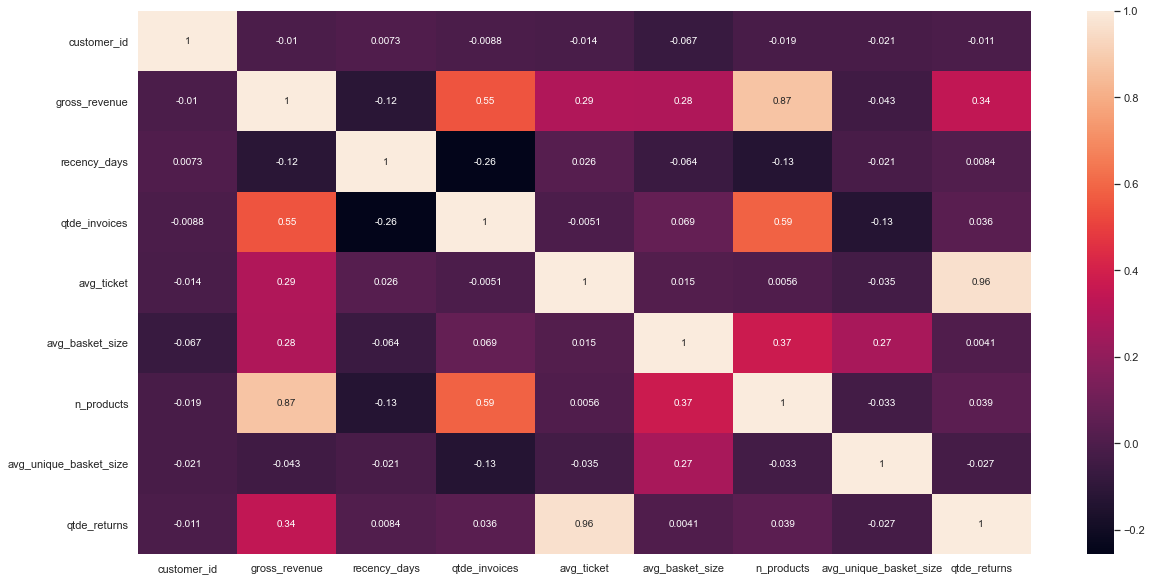

In [44]:
cor = df_ref.corr()

plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True)

In [45]:
df_ref.drop(columns=['avg_basket_size','avg_unique_basket_size'], inplace=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [46]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns
0,17850,5391.21,372.0,34.0,18.152222,1693,40.0
1,13047,3232.59,56.0,9.0,18.904035,1355,35.0
2,12583,6705.38,2.0,15.0,28.902500,4978,50.0
3,13748,948.25,95.0,5.0,33.866071,439,0.0
4,15100,876.00,333.0,3.0,292.000000,58,22.0


In [47]:
#df_tcc = df_ref.copy()
#df_tcc.columns=['customer_id','faturamento','recencia','frequencia','ticket_medio','n_produtos','devolucoes']
#df_tcc.head()

In [48]:
df5 = df_ref.copy()

In [49]:
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

In [50]:
df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
df5['n_products'] = mm.fit_transform( df5[['n_products']] )



In [51]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns
0,17850,0.019314,0.997319,0.165049,0.000235,0.010139,0.000494
1,13047,0.011581,0.150134,0.043689,0.000245,0.008422,0.000432
2,12583,0.024022,0.005362,0.072816,0.000374,0.026826,0.000617
3,13748,0.003397,0.254692,0.024272,0.000439,0.003769,0.000000
4,15100,0.003138,0.892761,0.014563,0.003783,0.001834,0.000272


In [52]:
df_tcc = df5.copy()
df_tcc.columns=['customer_id','faturamento','recencia','frequencia','ticket_medio','n_produtos','devolucoes']
df_tcc.head()

,customer_id,faturamento,recencia,frequencia,ticket_medio,n_produtos,devolucoes
0,17850,0.019314,0.997319,0.165049,0.000235,0.010139,0.000494
1,13047,0.011581,0.150134,0.043689,0.000245,0.008422,0.000432
2,12583,0.024022,0.005362,0.072816,0.000374,0.026826,0.000617
3,13748,0.003397,0.254692,0.024272,0.000439,0.003769,0.000000
4,15100,0.003138,0.892761,0.014563,0.003783,0.001834,0.000272


# 6.0 HYPERPARAMETER FOR FINE-TUNNING

In [53]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
X = df5.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns
0,0.019314,0.997319,0.165049,0.000235,0.010139,0.000494
1,0.011581,0.150134,0.043689,0.000245,0.008422,0.000432
2,0.024022,0.005362,0.072816,0.000374,0.026826,0.000617
3,0.003397,0.254692,0.024272,0.000439,0.003769,0.000000
4,0.003138,0.892761,0.014563,0.003783,0.001834,0.000272


## 6.1 K-Means

In [55]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics         as m
from sklearn import cluster         as c

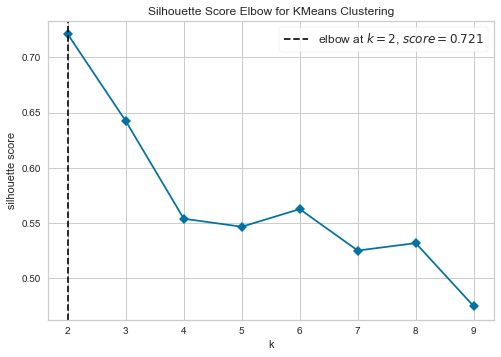

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [56]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

In [57]:
kmeans_list = []
for k in clusters:

    # model definition
    
    kmeans_model = c.KMeans(n_clusters=k)
    
    # model training
    
    kmeans_model.fit(X)
    
    # model predict
    
    labels = kmeans_model.predict(X)
    
    # model performance
    
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'KMEANS: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

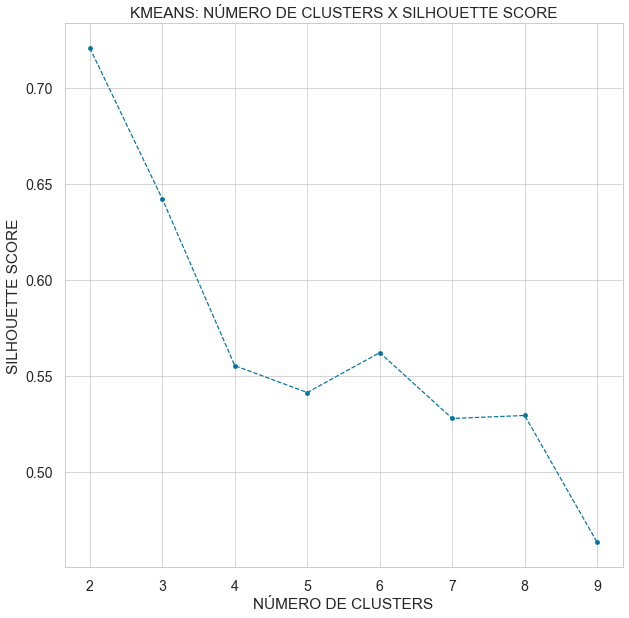

In [63]:
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(10,10))
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('KMEANS: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

In [59]:
kmeans_list

[0.7207152201491076,
 0.6421704970575076,
 0.5553550649571386,
 0.5413785290387335,
 0.5621579522154799,
 0.5278527600033792,
 0.529420148902753,
 0.4633800404647067]

## 6.2 GMM

In [60]:
X

,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns
0,0.019314,0.997319,0.165049,0.000235,0.010139,0.000494
1,0.011581,0.150134,0.043689,0.000245,0.008422,0.000432
2,0.024022,0.005362,0.072816,0.000374,0.026826,0.000617
3,0.003397,0.254692,0.024272,0.000439,0.003769,0.000000
4,0.003138,0.892761,0.014563,0.003783,0.001834,0.000272
...,...,...,...,...,...,...
4357,0.000705,0.002681,0.004854,0.000213,0.001925,0.000000
4358,0.001231,0.002681,0.004854,0.000247,0.003134,0.000000
4359,0.001290,0.002681,0.004854,0.002332,0.002027,0.000000
4360,0.000815,0.002681,0.004854,0.000246,0.001940,0.000000


In [68]:
gmm_list = []
for k in clusters:

    # model definition
    
    gmm_model = mx.GaussianMixture(n_components=k)
    
    # model training
    
    gmm_model.fit(X)
    
    # model predict
    
    labels = gmm_model.predict(X)
    
    # model performance
    
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'GMM: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

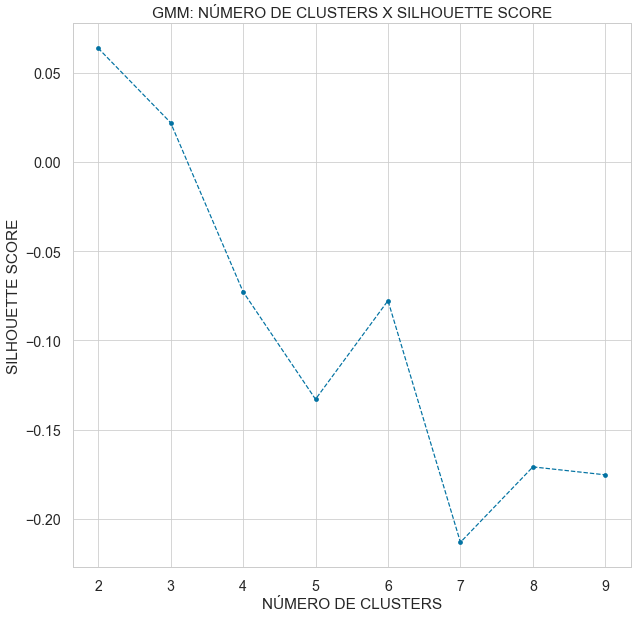

In [69]:
plt.figure(figsize=(10,10))
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('GMM: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

## 6.3 Hierarchical Clustering

In [65]:
#hc_model = hc.linkage(X, 'ward')
#
#plt.figure(figsize=(20,10))
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8
#
#    )
#
#plt.plot()

In [66]:
hc_list = []
for k in clusters:

    # model definition & training
    
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

Text(0.5, 1.0, 'HIERÁRQUICO: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

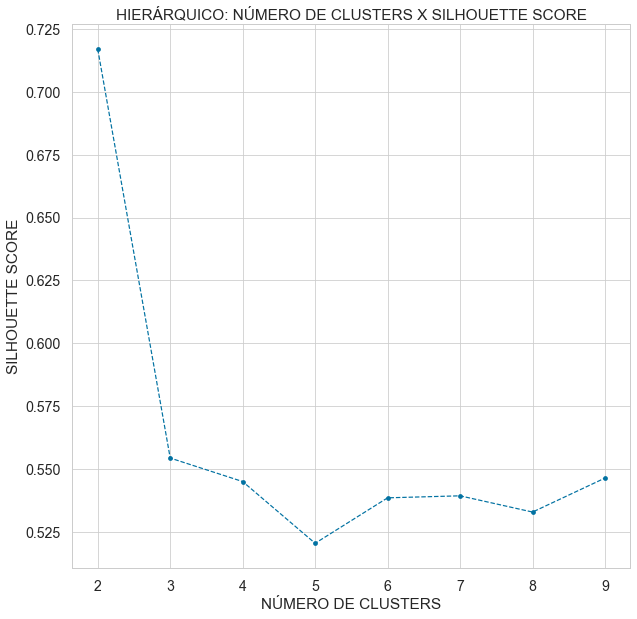

In [67]:
plt.figure(figsize=(10,10))
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('HIERÁRQUICO: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

# 7.0 RESULTADOS

In [66]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list
    }

).T

df_results.columns = clusters

In [67]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9
KMeans,0.720715,0.642170,0.555356,0.543279,0.562708,0.527853,0.529420,0.471854
GMM,0.063849,0.022094,-0.133657,-0.132961,-0.193292,-0.073533,-0.094280,-0.104115
HC,0.717008,0.554284,0.544927,0.520364,0.538455,0.539252,0.532791,0.546325


# 8.0 MODELO FINAL

In [68]:
# model definition

k = 6

kmeans = c.KMeans(n_clusters=k)

# model training

kmeans.fit(X)


# clustering

labels = kmeans.labels_




In [69]:
df8 = df_ref.copy()
df8['cluster'] = labels
df8.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns,cluster
0,17850,5391.21,372.0,34.0,18.152222,1693,40.0,0
1,13047,3232.59,56.0,9.0,18.904035,1355,35.0,3
2,12583,6705.38,2.0,15.0,28.902500,4978,50.0,1
3,13748,948.25,95.0,5.0,33.866071,439,0.0,3
4,15100,876.00,333.0,3.0,292.000000,58,22.0,0


In [70]:
# número de clientes

df_cluster = df8[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id'] / (df_cluster['customer_id'].sum()) * 100

# avg gross revenue
df_avg_gross_revenue = df8[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# avg recency days
df_avg_recency_days = df8[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# avg invoice_no
df_qtde_invoices = df8[['qtde_invoices', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_invoices, how='inner', on='cluster' )

# avg ticket
df_avg_ticket = df8[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket, how='inner', on='cluster' )

# avg returns
df_qtde_returns = df8[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

In [71]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_invoices,avg_ticket,qtde_returns
5,5,23,0.527281,89564.725217,5.565217,70.695652,2603.765044,4596.739130
1,1,2075,47.569922,2322.789894,17.838072,5.752289,29.128579,25.410120
3,3,1032,23.658872,1036.647355,73.414729,2.681202,29.983040,8.956395
2,2,509,11.668959,729.771454,160.852652,2.102161,63.433592,7.225933
0,0,291,6.671252,648.007801,336.065292,1.357388,302.603549,259.164948
4,4,432,9.903714,597.907245,248.270833,1.439815,53.149742,30.870370


In [72]:
df_cluster.columns = ['Cluster', 'Clientes','Percentual de Clientes','Faturamento Médio','Recência Média','Qtd Média de Pedidos','Ticket Médio','Qtd Média de Devoluções']

df_cluster.sort_values('Faturamento Médio', ascending=False)

,Cluster,Clientes,Percentual de Clientes,Faturamento Médio,Recência Média,Qtd Média de Pedidos,Ticket Médio,Qtd Média de Devoluções
5,5,23,0.527281,89564.725217,5.565217,70.695652,2603.765044,4596.739130
1,1,2075,47.569922,2322.789894,17.838072,5.752289,29.128579,25.410120
3,3,1032,23.658872,1036.647355,73.414729,2.681202,29.983040,8.956395
2,2,509,11.668959,729.771454,160.852652,2.102161,63.433592,7.225933
0,0,291,6.671252,648.007801,336.065292,1.357388,302.603549,259.164948
4,4,432,9.903714,597.907245,248.270833,1.439815,53.149742,30.870370


In [73]:
from sklearn import metrics as m

## WSS 

print('WSS value: {}'.format(kmeans.inertia_))

## SS

print( 'SS value: {}'.format(m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 20.750245063644634
SS value: 0.5625160227339006


## 8.1 Elbow Method

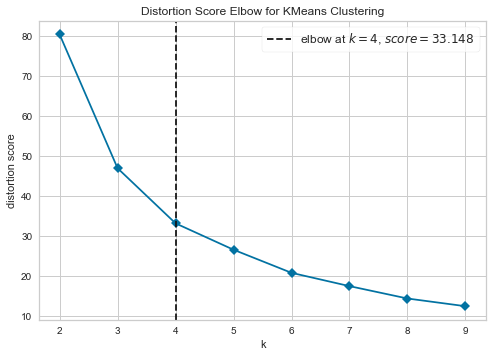

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

## 8.2 Silhouette Score

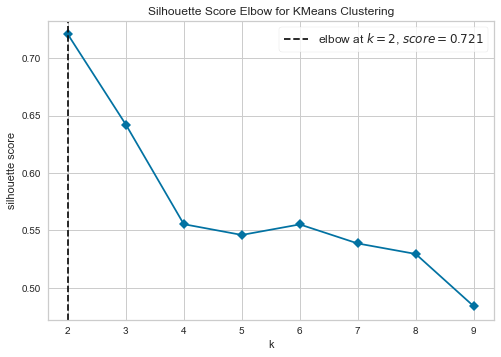

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [75]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

### 8.2.1 Análise visual da Silhouette

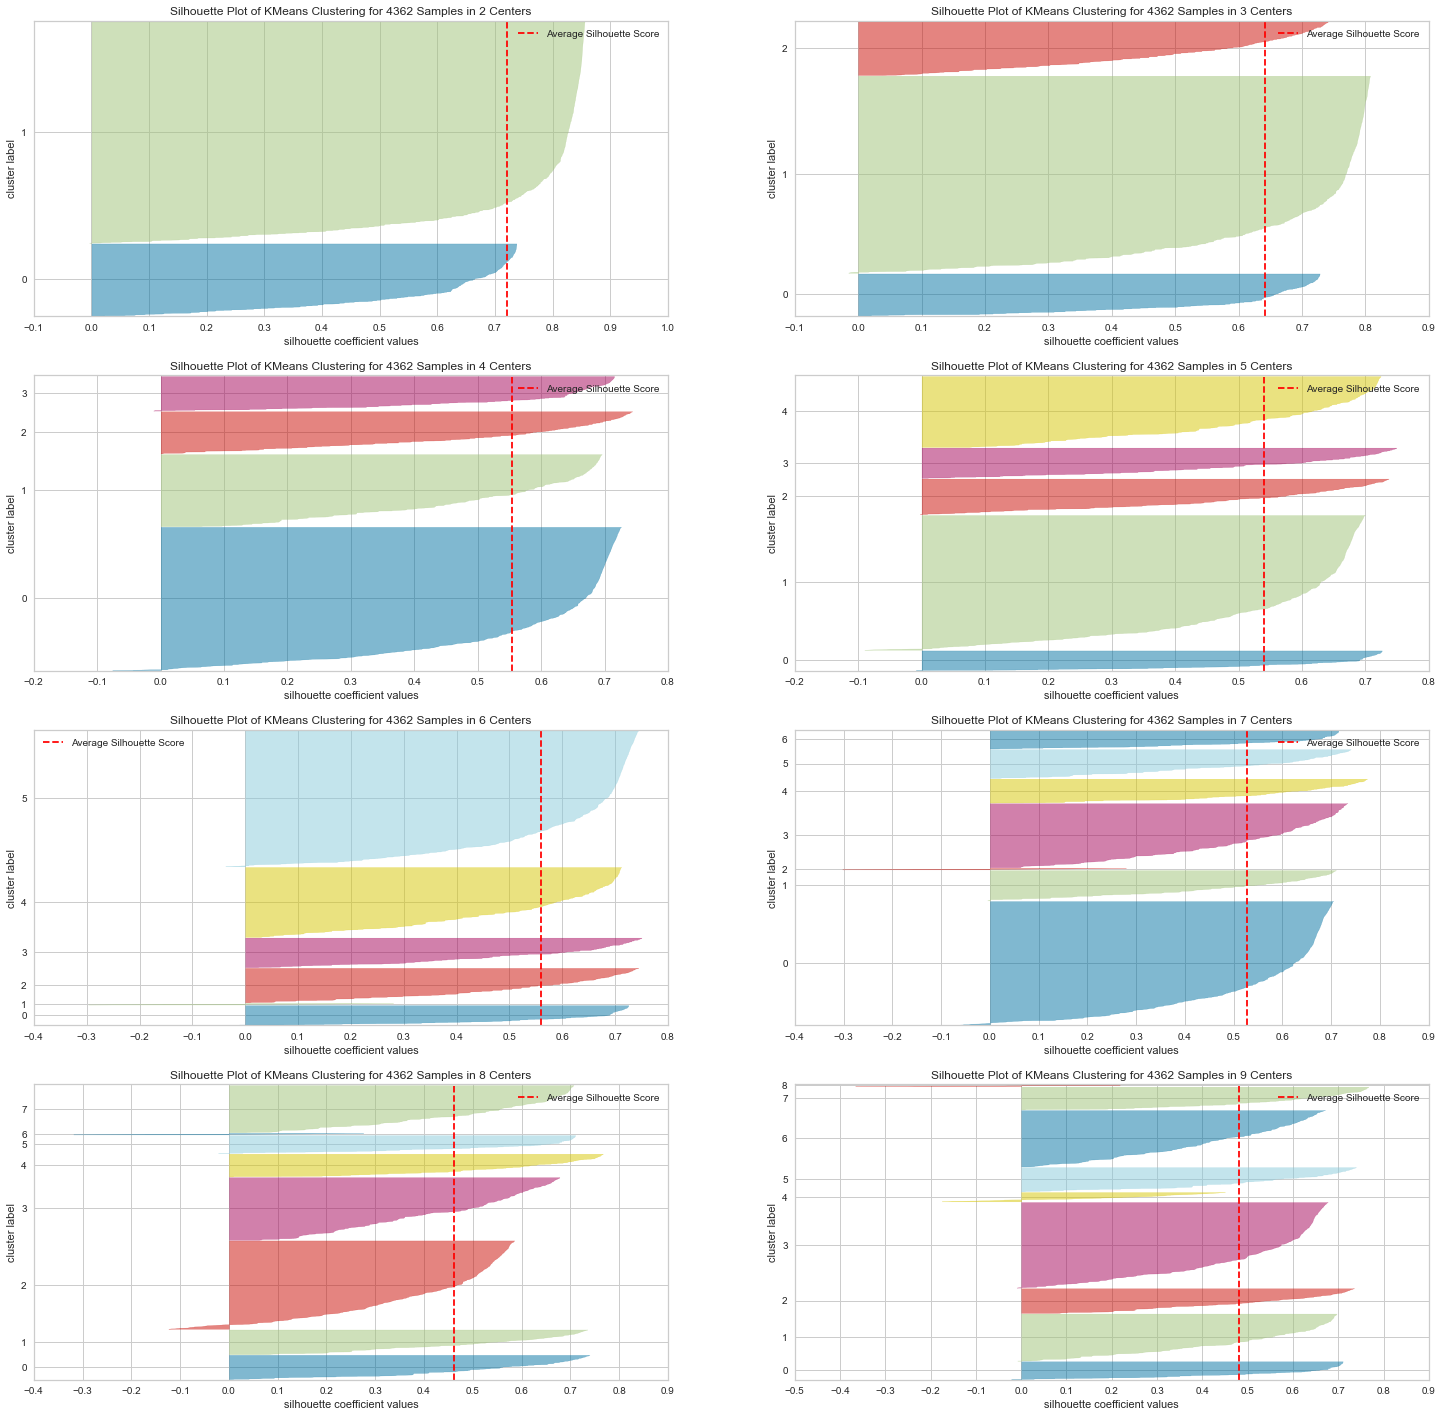

In [76]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 25) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 8.3 Visualização dos Clusteres

<AxesSubplot: title={'center': 'VISUALIZAÇÃO DOS CLUSTERS'}, xlabel='pca_0', ylabel='pca_1'>

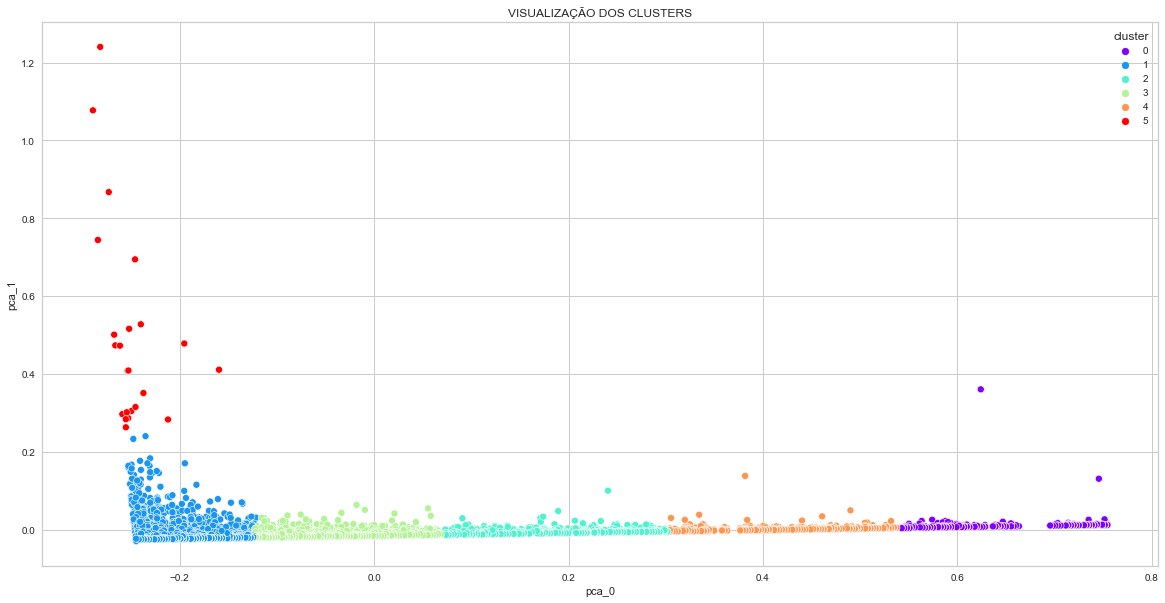

In [77]:
from sklearn import decomposition   as dd

pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable

features = range(pca.n_components_)

#plt.bar(features, pca.explained_variance_ratio_, color='orange')

# pca components

df_pca = pd.DataFrame(principal_components)

df_pca.rename(columns={0: 'pca_0', 1:'pca_1'}, inplace=True)

df_pca['cluster'] = labels


plt.figure(figsize=(20,10))
plt.title('VISUALIZAÇÃO DOS CLUSTERS')
sns.scatterplot( x='pca_0', 
                 y='pca_1',
                 hue='cluster',
                 data=df_pca,
                 palette='rainbow')

In [78]:
df8.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,avg_ticket,n_products,qtde_returns,cluster
0,17850,5391.21,372.0,34.0,18.152222,1693,40.0,0
1,13047,3232.59,56.0,9.0,18.904035,1355,35.0,3
2,12583,6705.38,2.0,15.0,28.902500,4978,50.0,1
3,13748,948.25,95.0,5.0,33.866071,439,0.0,3
4,15100,876.00,333.0,3.0,292.000000,58,22.0,0


In [79]:
df8.to_csv('Resultados/customers_cluster.csv',decimal=',',sep=';')